# Import Libraries

In [1]:
import rioxarray as rio
import os
from dask.distributed import Client, Lock
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sensus import *
import pandas as pd
from shapely.geometry import shape
import geopandas as gpd
from rasterio.features import shapes

## Set Data Path and Set Band Mapper

In [2]:
output_dir="output"

lc_files=[f"{output_dir}/{x}" for x in os.listdir("output") if "lc" in x and x.split(".")[-1] == "tif"]
lc_files.sort()

## Start Dask Client

In [3]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='10GB')

c:\Users\medo_\miniconda3\envs\geoai\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55791 instead
  warnings.warn(


# Extract Data from Time Series of Rasters

In [4]:

data_vals=list()

xx=None
yy=None
cols=list()


for lc_file in lc_files:
   
    date=lc_file.split("/")[-1].split("_")[0]
    name=f"lc_{date}"

    # # Read Surface Temperature Band
    lc=rio.open_rasterio(lc_file, chunks=True,  lock=Lock("rio-read")) # Read LST as DaskArray

    # Add XY Coordinates to dataset for spatial dimension
    # Only add once
    if xx is None and yy is None:
        x=lc.x.values # Get X coordinates from NDVI Raster
        y=lc.y.values # Get Y coordinates from NDVI Raster

        yy, xx = np.meshgrid(y, x, indexing="ij") # Reshape to grid matching raster dimensions
        
        # Add coordinates to data list
        data_vals.append(xx) 
        cols.append("x")
        data_vals.append(yy)
        cols.append("y")

    
    # Append Land Cover values to data list
    data_vals.append(lc.isel(band=0).values)
    cols.append(name)




## Get Raster Dimensions 

In [5]:

# Get Dimensions of the dataset to facilitate reshaping data later on
height=lc.rio.height
width=lc.rio.width
length=height * width
n_dims=len(data_vals)
orig_shape = (height,width)
data_shape = (length,n_dims)
res=lc.rio.resolution()
cell_area_m2=abs(res[0]) * abs(res[1])

## Run KMeans Clustering on Dataset

In [6]:

N_CLUSTERS= 21


# Transpose Extracted raster values into a shape suitable for KMeans
## Typically will be reshaped to (width * height, columns) 
data=np.stack(data_vals)
data=data.transpose(1,2,0).reshape(-1, n_dims)
data_df=pd.DataFrame(data,columns=cols) # Convert array to Pandas DataFrame, use col names retrieved from the data extraction step

mask=data_df.isna().any(axis=1) # Create a mask indicating which rows have NaN 
data_df.dropna(inplace=True) # Drop NaN to prepare clustering

data_df["label"]=kmeans_df(data_df, k=N_CLUSTERS) # Run KMeans clustering on the dataframe
data_df=data_df.astype(int)


## Convert label array to Raster Band

In [7]:
# Format Cluster Labels into XR DataArray - use NDVI dimensions to create the raster
cluster_map=np.full(length,np.nan)
cluster_map[~mask] = data_df.label.to_list()
cluster_raster=cluster_map.reshape((height, width))
cluster_da=lc.isel(band=0).copy()
cluster_da.values=cluster_raster

## Set Land Use Change Trend

In [8]:
import json
with open("output/classes.json") as classes:
    classes= json.load(classes)

class_map=dict(zip(classes.values(), classes.keys()))

vars=[x for x in data_df.columns if "lc" in x]

class_df=data_df[vars].apply(lambda x: x.map(class_map))
class_df["label"] = data_df["label"]
class_df=class_df.groupby("label").agg(pd.Series.mode).reset_index()



dates=[x.split("_")[-1] for x in vars]

lc_info_df=pd.DataFrame(class_df[vars].apply(lambda x: lc_change(x.to_list(), time_scale="Week"), axis=1).to_list())
lc_info_df["label"] = class_df.label


## Vectorize Identified Spatio Temporal Clusters

In [13]:

# Vectorize clustered raster to polygon shapes as GeoDataFrame
gdf=xr_vectorize(cluster_da,0,"class")


# Join mean values calculated for each cluster - support visualisation
gdf=gdf.set_index("class").join(lc_info_df.set_index("label"))
gdf=gdf[~gdf.label_name.isna()]
# gdf=gdf[gdf.label_name != "No Change"]

gdf.to_parquet(f"{output_dir}/kmeans_{N_CLUSTERS}_lc_25cm_.parquet")

c:\Users\medo_\miniconda3\envs\geoai\Lib\site-packages\xarray\core\duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [18]:
gdf_merged=gdf.dissolve(by="class",aggfunc="first")

In [ ]:
gdf_merged=gdf_merged[gdf_merged.label_name != "No Change"]

In [20]:
gdf_merged.to_parquet(f"{output_dir}/kmeans_{N_CLUSTERS}_lc_25cm_merged_.parquet")

<Axes: xlabel='label_name'>

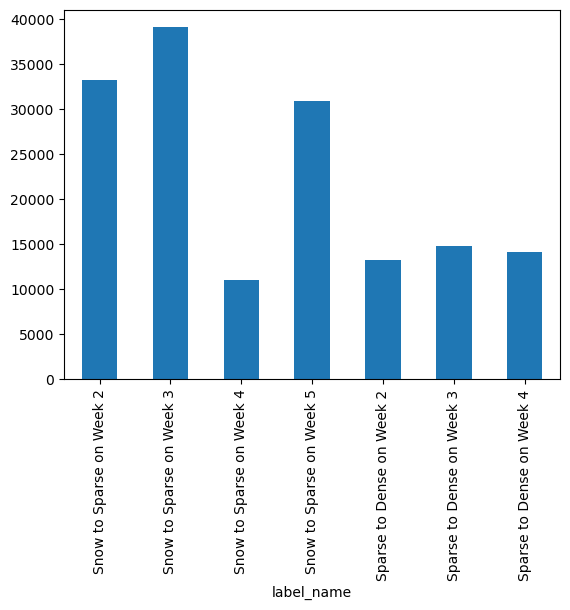

In [ ]:
gdf.groupby("label_name").area_m2.sum().plot.bar()